# Compare Portfolio Optimization methods from MyPortfolioOpt

In [1]:
# Notebook developed in Google Colab
!pip install PyPortfolioOpt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
sns.set()

     |████████████████████████████████| 61 kB 3.3 MB/s 
     |████████████████████████████████| 2.7 MB 10.6 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [2]:
# import dataset
ret = pd.read_excel("/content/drive/MyDrive/USstocks_logret.xlsx", index_col="Date")
ret.head()

,AAPL,BAC,JNJ,VWAGY,AMZN,NVDA,WMT,JPM,DIS,XOM,KO,GE,BA,T,MCD,FB,ATVI,GOOG,F,INTC
Date,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.028576,-0.029481,-0.007009,-0.038524,-0.020731,-0.017034,-0.002915,-0.031537,-0.014721,-0.027743,0.000000,-0.018526,-0.006950,-0.009493,-0.011106,-0.016191,-0.014007,-0.021066,-0.039846,-0.011340
2015-01-06,0.000094,-0.030376,-0.004926,0.010884,-0.023098,-0.030787,0.007676,-0.026271,-0.005318,-0.005330,0.007565,-0.021780,-0.011848,0.001489,0.001842,-0.013565,-0.018816,-0.023450,-0.009530,-0.018813
2015-01-07,0.013925,0.004734,0.021836,0.005278,0.010544,-0.002609,0.026186,0.001525,0.010178,0.010081,0.012405,0.000416,0.015407,0.001207,0.017274,0.000000,-0.021796,-0.001715,0.028323,0.020758
2015-01-08,0.037703,0.020451,0.007832,0.025049,0.006813,0.036928,0.020887,0.022100,0.010288,0.016507,0.012023,0.011971,0.017527,0.009900,0.003716,0.026309,0.009919,0.003148,0.024952,0.018430
2015-01-09,0.001072,-0.018092,-0.013723,-0.017183,-0.011818,0.004020,-0.012457,-0.017540,0.004892,-0.001410,-0.011093,-0.014050,-0.001975,-0.002989,-0.012262,-0.005644,-0.018349,-0.013035,-0.013712,0.001906


## Examples of Portfolio Optimization: Mean-Variance Optimization

EfficientFrontier class: **pypfopt.efficient_frontier.
EfficientFrontier(expected_returns, cov_matrix, weight_bounds=(0, 1), solver=None, verbose=False, solver_options=None)**

---
Methods shown below:
1.   **Minimize volatility (MVP portfolio)**: min_volatility()
2.   **Maximize Sharpe ratio**: max_sharpe() (not working always) 

Other available methods:
1.   **Maximize the quadratic utility**: (max_quadratic_utility(risk_aversion=1, market_neutral=False))
2.   **Maximize return given target risk level**: (efficient_risk(target_volatility, market_neutral=False))
3.   **Minimize risk given target return**: (efficient_return(target_return, market_neutral=False))


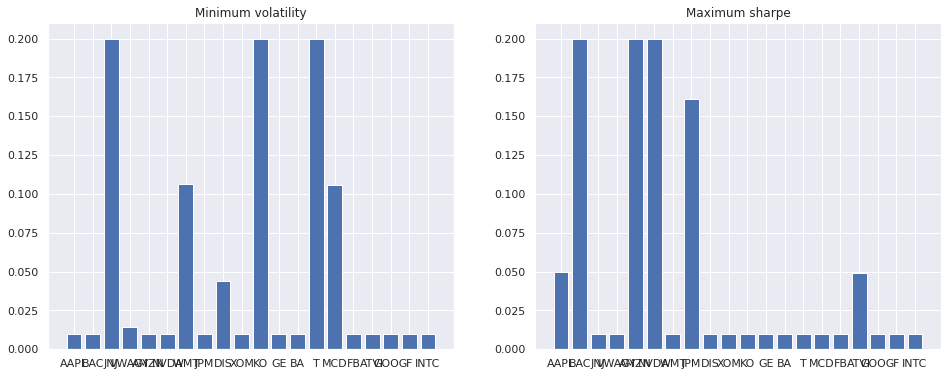

In [3]:
# Define required variables and parameters
train_ret = ret.iloc[0:500, :]   # first 2 years
mu = train_ret.mean()
cov = train_ret.cov()

############ Initialize the class
from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(expected_returns=mu, cov_matrix=cov, weight_bounds=(0.01, 0.2))  # minimum weight= 5%, max=40%
############ MINIMIZE VOLATILITY
ef.min_volatility()
wminvol = ef.clean_weights()
w1 = np.fromiter(wminvol.values(), dtype=float)

############ MAXIMIZE SHARPE
#ef.max_sharpe(risk_free_rate=0.005)  # possible errors if expected returns are negative
# Solve max_sharpe problem
from pypfopt import objective_functions

min_weight, max_weight = 0.01, 0.2
wmaxs = ef.nonconvex_objective(
        objective_functions.sharpe_ratio,
        objective_args=(ef.expected_returns, ef.cov_matrix),
        constraints=[
            {"type": "eq", "fun": lambda w: np.sum(w) - 1},     # sum to 1
            {"type": "ineq", "fun": lambda w: w - min_weight},  # greater than min_weight
            {"type": "ineq", "fun": lambda w: max_weight - w},  # less than max_weight
        ])
wmaxs = ef.clean_weights()
w2 = np.fromiter(wmaxs.values(), dtype=float)

# Plot the weights
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.bar(wminvol.keys(), w1)
ax1.set_title("Minimum volatility")
ax2.bar(wmaxs.keys(), w2)
ax2.set_title("Maximum sharpe");

## Examples of Portfolio Optimization: Methods based on Tail Risk metrics

pypfopt.efficient_frontier.EfficientSemivariance(expected_returns, returns, frequency=252, benchmark=0, weight_bounds=(0, 1))

1.   **Efficient Semivariance**: min_semivariance(market_neutral=False)

pypfopt.efficient_frontier.EfficientCVaR(expected_returns, returns, beta=0.95, weight_bounds=(0, 1))

2.   **Efficient CVaR**: min_cvar(market_neutral=False)

pypfopt.efficient_frontier.EfficientCDaR(expected_returns, returns, beta=0.95, weight_bounds=(0, 1))
3.   **Efficient CDaR**: min_cdar(market_neutral=False)

Alternative methods as before, for each option.



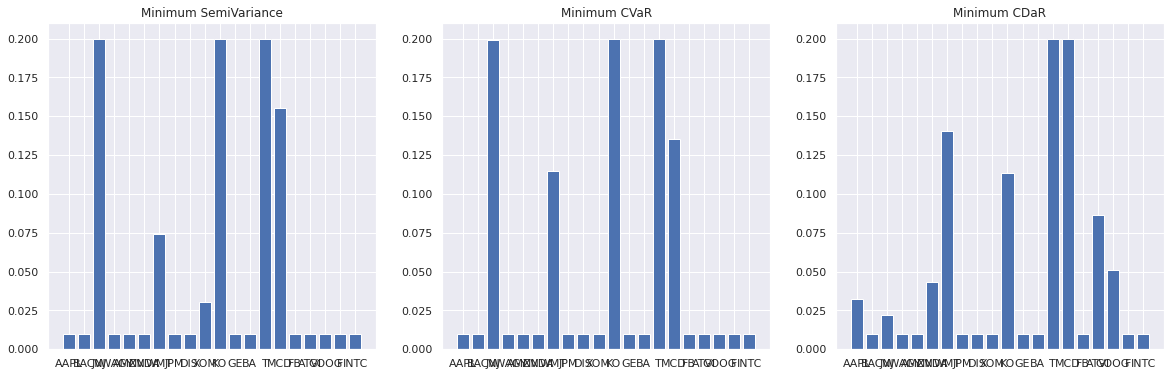

In [4]:
######### MINIMIZE SEMIVARIANCE
from pypfopt.efficient_frontier import EfficientSemivariance
efsv = EfficientSemivariance(expected_returns=mu, returns = train_ret, weight_bounds=(0.01, 0.2))
efsv.min_semivariance()
wsemi = efsv.clean_weights()
wsemi1 = np.fromiter(wsemi.values(), dtype=float)

######### MINIMIZE CVAR
from pypfopt.efficient_frontier import EfficientCVaR
efc = EfficientCVaR(expected_returns=mu, returns = train_ret, beta=0.97, weight_bounds=(0.01, 0.2))
efc.min_cvar()
wc = efc.clean_weights()
wc1 = np.fromiter(wc.values(), dtype=float)

######### MINIMIZE CDAR
from pypfopt.efficient_frontier import EfficientCDaR
efd = EfficientCDaR(expected_returns=mu, returns = train_ret, beta=0.97, weight_bounds=(0.01, 0.2))
efd.min_cdar()
wd = efd.clean_weights()
wd1 = np.fromiter(wd.values(), dtype=float)

# Plot the weights
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
ax1.bar(wsemi.keys(), wsemi1)
ax1.set_title("Minimum SemiVariance")
ax2.bar(wc.keys(), wc1)
ax2.set_title("Minimum CVaR");
ax3.bar(wd.keys(), wd1)
ax3.set_title("Minimum CDaR");

## Examples of Portfolio Optimization: Hierarchical Risk Parity

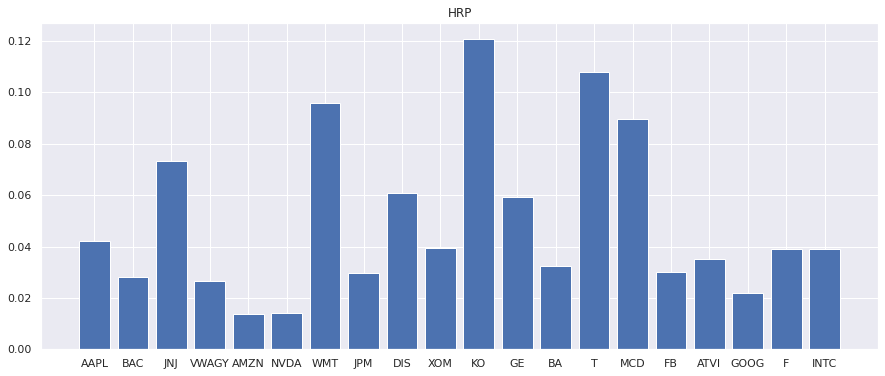

In [5]:
# Initialize the class
from pypfopt.hierarchical_portfolio import HRPOpt

hrp = HRPOpt(returns = train_ret, cov_matrix = cov)
hrp.optimize(linkage_method='single')
whrp = hrp.clean_weights()
whrp1 = np.fromiter(whrp.values(), dtype=float)

plt.figure(figsize=(15,6))
plt.bar(whrp.keys(), whrp1)
plt.title("HRP");

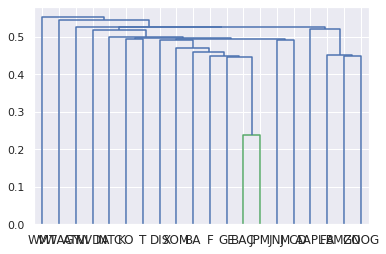

In [6]:
# Plot Dendrogram for HRP
from scipy.cluster import hierarchy
dn = hierarchy.dendrogram(hrp.clusters, labels=ret.columns)

# Simulate portfolio performance with weights rebalancing over time

Initial training period: 1 years

Rebalancing frequency: 1 year / 1 month

## Example for MVP and MAX_SHARPE portfolios

In [8]:
# Backtest portfolio performance with different optimization methods

def get_pfret_backtestMVPMS(returns_df, in_tr, freq):
    """
    TEST WITH MINIMUM VOLATILITY and MAX SHARPE Portfolios.
    ARGUMENTS: 
    - returns_df: pd.DataFrame, log returns for all assets
    - in_tr: int, number of DAYS as initial training period
    - freq: int, number of DAYS after which weights rebalancing occurs
    OUTPUT: pandas DataFrame, single components and portfolios returns with rebalanced weights
    """
    df_l = returns_df.copy()
    # log to arithmetic to compute pf returns
    df = np.exp(df_l)-1
    periods = math.floor((len(df)-in_tr)/freq)
    
    # Define weights containers, pfret containers and new column in dataframe for each method used
    pfret1 = np.zeros(len(df))  
    all_w1 = []
    pfret2 = np.zeros(len(df))  
    all_w2 = []

    for i in range (periods):
        # Define inputs for the class
        train_ret = df.iloc[i*freq:(in_tr+(i*freq))] 
        mu = train_ret.mean()
        covmat = train_ret.cov()
        if i == (periods-1): 
            test_ret = df.iloc[((in_tr+(i*freq))+1):]
        else: 
            test_ret = df.iloc[((in_tr+(i*freq))+1):(in_tr+((i+1)*freq))]

        # Compute weights with different methods 
        # Initialize class
        ef = EfficientFrontier(expected_returns=mu, cov_matrix=covmat, weight_bounds=(0.01, 0.2))
        # MINIMIZE VOLATILITY
        ef.min_volatility()
        wminvol = ef.clean_weights()
        w1 = np.fromiter(wminvol.values(), dtype=float)
        # MAXIMIZE SHARPE
        min_weight, max_weight = 0.01, 0.2
        wmaxs = ef.nonconvex_objective(
                objective_functions.sharpe_ratio,
                objective_args=(ef.expected_returns, ef.cov_matrix),
                constraints=[
                    {"type": "eq", "fun": lambda w: np.sum(w) - 1},     
                    {"type": "ineq", "fun": lambda w: w - min_weight},
                    {"type": "ineq", "fun": lambda w: max_weight - w},
                ])
        wmaxs = ef.clean_weights()
        w2 = np.fromiter(wmaxs.values(), dtype=float)

        # Store weights for this period (one for each method)
        all_w1.append([w1])  
        all_w2.append([w2])            
        ret = np.matrix(test_ret) # put returns in a matrix (used for both)

        # Compute pf returns
        if i == (periods-1): 
            # One for each opt methods
            pfret1[((in_tr+(i*freq))+1):] = np.fromiter(np.sum(np.multiply(ret, w1), axis=1), dtype=float)
            pfret2[((in_tr+(i*freq))+1):] = np.fromiter(np.sum(np.multiply(ret, w2), axis=1), dtype=float)
        else:
            # One for each opt methods
            pfret1[((in_tr+(i*freq))+1):(in_tr+((i+1)*freq))] = np.fromiter(np.sum(np.multiply(ret, w1), axis=1), dtype=float)
            pfret2[((in_tr+(i*freq))+1):(in_tr+((i+1)*freq))] = np.fromiter(np.sum(np.multiply(ret, w2), axis=1), dtype=float)
    
    # Add a benchmark (equal weights pf)
    r = np.matrix(df) 
    weq = np.array([1/len(df.columns)]*len(df.columns))
    eq_a = np.sum(np.multiply(r, weq), axis=1)
    # back to log
    df_l["Benchmark"] = np.log(1+eq_a)
    # One for each opt methods
    df_l["PF_MVP"] = np.log(1+pfret1)
    df_l["PF_MS"] = np.log(1+pfret2)
    return df_l.iloc[(in_tr+1):], all_w1, all_w2 # One for each opt method


data_ret, wseries1, wseries2 = get_pfret_backtestMVPMS(ret, 252, 252) # 1 year training, 1 year rebalancing
data_ret.head(3)


,AAPL,BAC,JNJ,VWAGY,AMZN,NVDA,WMT,JPM,DIS,XOM,KO,GE,BA,T,MCD,FB,ATVI,GOOG,F,INTC,Benchmark,PF_MVP,PF_MS
Date,,,,,,,,,,,,,,,,,,,,,,,
2016-01-06,-0.019764,-0.021533,-0.005068,-0.007082,-0.001800,-0.042229,0.009963,-0.014541,-0.005366,-0.008355,-0.005420,-0.016069,-0.016006,-0.001467,-0.006734,0.002333,-0.009468,0.001400,-0.045479,-0.022419,-0.011665,-0.004095,-0.013605
2016-01-07,-0.043121,-0.036736,-0.011723,-0.046926,-0.039841,-0.040452,0.023022,-0.041280,-0.008606,-0.016136,-0.016679,-0.043235,-0.042826,-0.016280,-0.023414,-0.050287,-0.014235,-0.023443,-0.031774,-0.038205,-0.027956,-0.013449,-0.033963
2016-01-08,0.005274,-0.019545,-0.010741,0.016914,-0.001465,-0.021700,-0.023179,-0.022654,-0.002516,-0.020409,-0.002647,-0.018113,-0.022967,0.000895,-0.001558,-0.006044,-0.015560,-0.016546,-0.012678,-0.010418,-0.010224,-0.007209,-0.012251


In [9]:
# Put weights in a df to explore their evolution
w_ser1 = np.vstack(wseries1)
dweights1 = pd.DataFrame(w_ser1, columns=ret.columns)
w_ser2 = np.vstack(wseries2)
dweights2 = pd.DataFrame(w_ser2, columns=ret.columns)

# # plot evolution
# dweights1.plot(kind='bar', stacked=True, figsize=(8,6))
# plt.title("Weights evolution for MVP Portfolio", fontsize=15);
# dweights2.plot(kind='bar', stacked=True, figsize=(8,6))
# plt.title("Weights evolution for Max Sharpe Portfolio", fontsize=15);

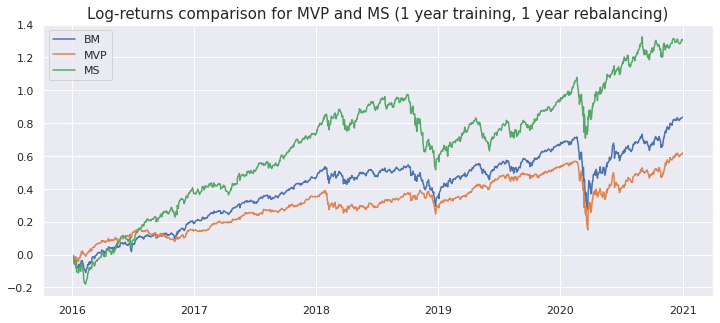

In [10]:
# Compare cumulative log ret
plt.figure(figsize=(12,5))
plt.plot(data_ret["Benchmark"].cumsum())
plt.plot(data_ret["PF_MVP"].cumsum())
plt.plot(data_ret["PF_MS"].cumsum())
plt.legend(["BM", "MVP", "MS"])
plt.title("Log-returns comparison for MVP and MS (1 year training, 1 year rebalancing)", fontsize=15);

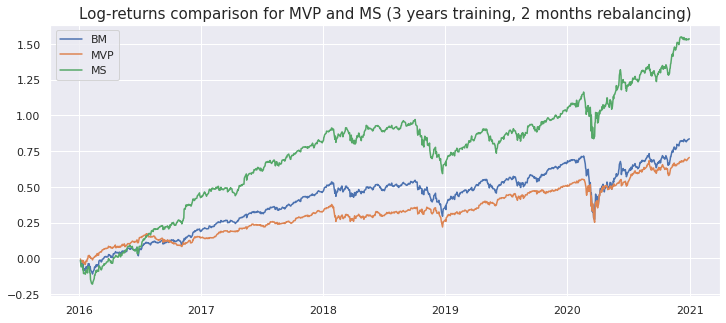

In [11]:
######### Repeat with different rebalancing period (1 year train, 1 month rebalancing)
data_ret2 = get_pfret_backtestMVPMS(ret, 252, 30)[0]

# Compare cumulative log ret
plt.figure(figsize=(12,5))
plt.plot(data_ret2["Benchmark"].cumsum())
plt.plot(data_ret2["PF_MVP"].cumsum())
plt.plot(data_ret2["PF_MS"].cumsum())
plt.legend(["BM", "MVP", "MS"])
plt.title("Log-returns comparison for MVP and MS (3 years training, 2 months rebalancing)", fontsize=15);

## Example for Semivariance, CVaR, CDaR and HRP

In [13]:

def get_pfret_backtestAlt(returns_df, in_tr, freq):
    """
    TEST WITH Alternative optimization methods (Minimize Semivariance, CVaR and CDaR).
    ARGUMENTS: 
    - returns_df: pd.DataFrame, log returns for all assets
    - in_tr: int, number of DAYS as initial training period
    - freq: int, number of DAYS after which weights rebalancing occurs
    OUTPUT: pandas DataFrame, single components and portfolios returns with rebalanced weights
    """
    df_l = returns_df.copy()
    df = np.exp(df_l)-1
    periods = math.floor((len(df)-in_tr)/freq)
    
    # Define weights containers, pfret containers and new column in dataframe for each method used
    pfret1 = np.zeros(len(df))  
    all_w1 = []
    pfret2 = np.zeros(len(df))  
    all_w2 = []
    pfret3 = np.zeros(len(df))  
    all_w3 = []
    pfret4 = np.zeros(len(df))  
    all_w4 = []

    for i in range (periods):
        # Define inputs for the class
        train_ret = df.iloc[i*freq:(in_tr+(i*freq))] 
        mu = train_ret.mean()
        cov = train_ret.cov()
        if i == (periods-1): 
            test_ret = df.iloc[((in_tr+(i*freq))+1):]
        else: 
            test_ret = df.iloc[((in_tr+(i*freq))+1):(in_tr+((i+1)*freq))]

        # Compute weights with different methods 
        # Initialize class
        esv = EfficientSemivariance(expected_returns=mu, returns=train_ret, weight_bounds=(0.01, 0.2))
        ecv = EfficientCVaR(expected_returns=mu, returns=train_ret, beta=0.97, weight_bounds=(0.01, 0.2))
        ecd = EfficientCDaR(expected_returns=mu, returns=train_ret, beta=0.97, weight_bounds=(0.01, 0.2))
        hrp = HRPOpt(returns = train_ret, cov_matrix = cov)
        # Semivariance
        esv.min_semivariance()
        wesv = esv.clean_weights()
        w1 = np.fromiter(wesv.values(), dtype=float)
        # CVaR
        ecv.min_cvar()
        wecv = ecv.clean_weights()
        w2 = np.fromiter(wecv.values(), dtype=float)
        # CDaR
        ecd.min_cdar()
        wecd = ecd.clean_weights()
        w3 = np.fromiter(wecd.values(), dtype=float)
        # HRP
        hrp.optimize(linkage_method='single')
        whrp = hrp.clean_weights()
        w4 = np.fromiter(whrp.values(), dtype=float)

        # Store weights for this period (one for each method)
        all_w1.append([w1])  
        all_w2.append([w2])  
        all_w3.append([w3]) 
        all_w4.append([w4])            
        ret = np.matrix(test_ret) # put returns in a matrix (used for both)

        # Compute pf returns
        if i == (periods-1): 
            # One for each opt methods
            pfret1[((in_tr+(i*freq))+1):] = np.fromiter(np.sum(np.multiply(ret, w1), axis=1), dtype=float)
            pfret2[((in_tr+(i*freq))+1):] = np.fromiter(np.sum(np.multiply(ret, w2), axis=1), dtype=float)
            pfret3[((in_tr+(i*freq))+1):] = np.fromiter(np.sum(np.multiply(ret, w3), axis=1), dtype=float)
            pfret4[((in_tr+(i*freq))+1):] = np.fromiter(np.sum(np.multiply(ret, w4), axis=1), dtype=float)
        else:
            # One for each opt methods
            pfret1[((in_tr+(i*freq))+1):(in_tr+((i+1)*freq))] = np.fromiter(np.sum(np.multiply(ret, w1), axis=1), dtype=float)
            pfret2[((in_tr+(i*freq))+1):(in_tr+((i+1)*freq))] = np.fromiter(np.sum(np.multiply(ret, w2), axis=1), dtype=float)
            pfret3[((in_tr+(i*freq))+1):(in_tr+((i+1)*freq))] = np.fromiter(np.sum(np.multiply(ret, w3), axis=1), dtype=float)
            pfret4[((in_tr+(i*freq))+1):(in_tr+((i+1)*freq))] = np.fromiter(np.sum(np.multiply(ret, w4), axis=1), dtype=float)
    
    # Add a benchmark (equal weights pf)
    r = np.matrix(df) 
    weq = np.array([1/len(df.columns)]*len(df.columns))
    eq_a = np.sum(np.multiply(r, weq), axis=1)
    # back to log
    df_l["Benchmark"] = np.log(1+eq_a)
    # One for each opt methods
    df_l["PF_MSV"] = np.log(1+pfret1)
    df_l["PF_MCVaR"] = np.log(1+pfret2)
    df_l["PF_MCDaR"] = np.log(1+pfret3)
    df_l["PF_HRP"] = np.log(1+pfret4)
    return df_l.iloc[(in_tr+1):], all_w1, all_w2, all_w3, all_w4 # One for each opt method


data_alt = get_pfret_backtestAlt(ret, 252, 252)[0] 
data_alt.head(3)

,AAPL,BAC,JNJ,VWAGY,AMZN,NVDA,WMT,JPM,DIS,XOM,KO,GE,BA,T,MCD,FB,ATVI,GOOG,F,INTC,Benchmark,PF_MSV,PF_MCVaR,PF_MCDaR,PF_HRP
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-06,-0.019764,-0.021533,-0.005068,-0.007082,-0.001800,-0.042229,0.009963,-0.014541,-0.005366,-0.008355,-0.005420,-0.016069,-0.016006,-0.001467,-0.006734,0.002333,-0.009468,0.001400,-0.045479,-0.022419,-0.011665,-0.005634,-0.004175,-0.007620,-0.008580
2016-01-07,-0.043121,-0.036736,-0.011723,-0.046926,-0.039841,-0.040452,0.023022,-0.041280,-0.008606,-0.016136,-0.016679,-0.043235,-0.042826,-0.016280,-0.023414,-0.050287,-0.014235,-0.023443,-0.031774,-0.038205,-0.027956,-0.017721,-0.014889,-0.019958,-0.021090
2016-01-08,0.005274,-0.019545,-0.010741,0.016914,-0.001465,-0.021700,-0.023179,-0.022654,-0.002516,-0.020409,-0.002647,-0.018113,-0.022967,0.000895,-0.001558,-0.006044,-0.015560,-0.016546,-0.012678,-0.010418,-0.010224,-0.005699,-0.006446,-0.007315,-0.009558


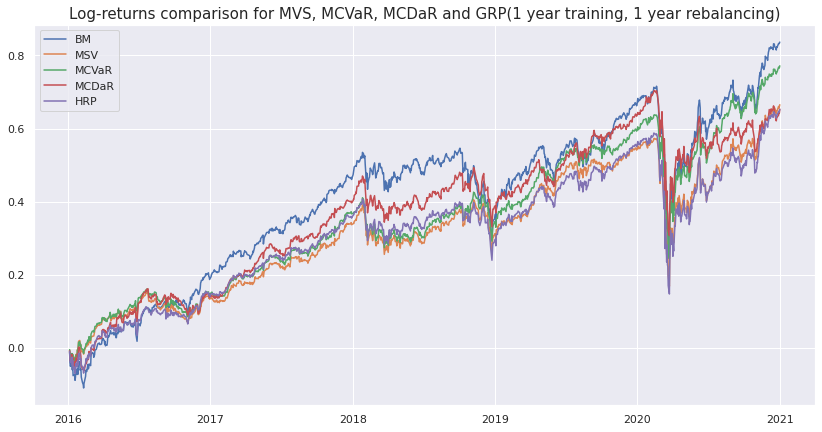

In [14]:
# Compare cumulative log ret
plt.figure(figsize=(14,7))
plt.plot(data_alt["Benchmark"].cumsum())
plt.plot(data_alt["PF_MSV"].cumsum())
plt.plot(data_alt["PF_MCVaR"].cumsum())
plt.plot(data_alt["PF_MCDaR"].cumsum())
plt.plot(data_alt["PF_HRP"].cumsum())
plt.legend(["BM", "MSV", "MCVaR", "MCDaR", "HRP"])
plt.title("Log-returns comparison for MVS, MCVaR, MCDaR and GRP(1 year training, 1 year rebalancing)", fontsize=15);

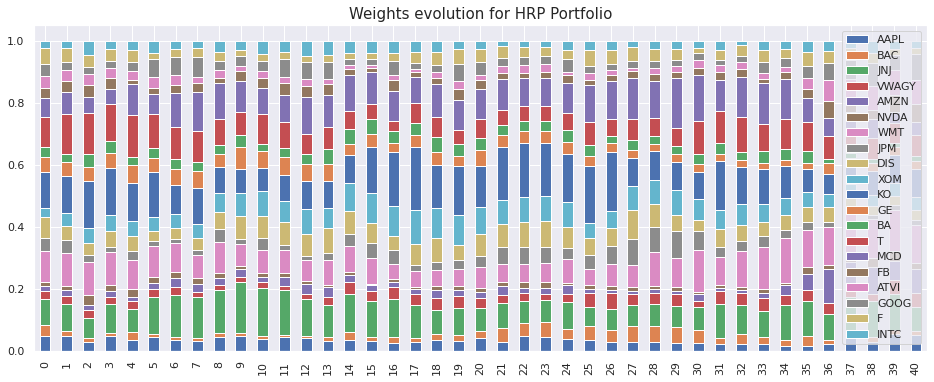

In [15]:
# Alternative parameters
# Put HRP weights in a df and explore their evolution
w_serHRP = get_pfret_backtestAlt(ret, 252, 30)[4]
w_serHRP = np.vstack(w_serHRP)
dwserHRP = pd.DataFrame(w_serHRP, columns=ret.columns)

# plot evolution
dwserHRP.plot(kind='bar', stacked=True, figsize=(16,6))
plt.title("Weights evolution for HRP Portfolio", fontsize=15);

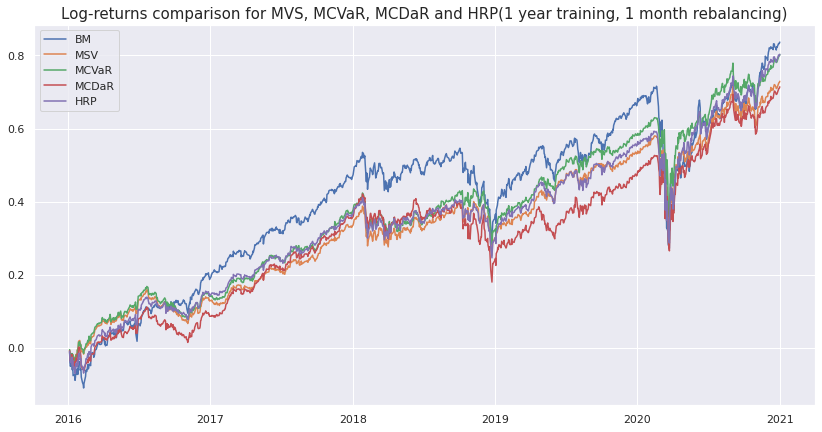

In [16]:
# Alternative parameters
data_alt1 = get_pfret_backtestAlt(ret, 252, 30)[0]
plt.figure(figsize=(14,7))
plt.plot(data_alt1["Benchmark"].cumsum())
plt.plot(data_alt1["PF_MSV"].cumsum())
plt.plot(data_alt1["PF_MCVaR"].cumsum())
plt.plot(data_alt1["PF_MCDaR"].cumsum())
plt.plot(data_alt1["PF_HRP"].cumsum())
plt.legend(["BM", "MSV", "MCVaR", "MCDaR", "HRP"])
plt.title("Log-returns comparison for MVS, MCVaR, MCDaR and HRP(1 year training, 1 month rebalancing)", fontsize=15);

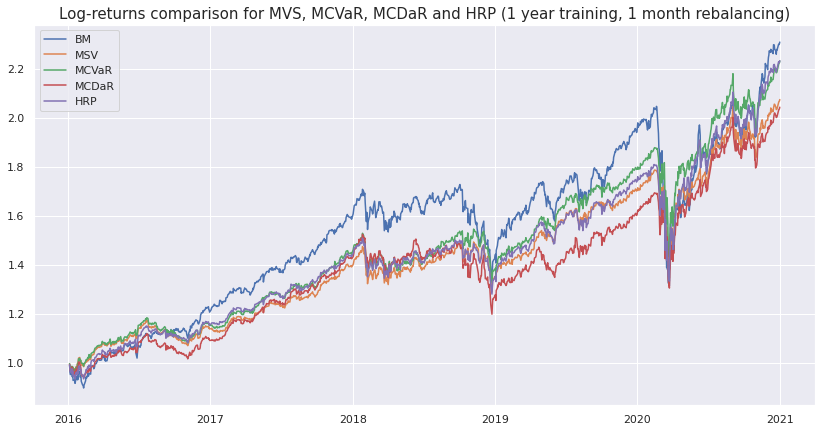

In [17]:
# Alternative way to plot results
# In this way you visualize the gross performance IN TERMS OF ARITHMETIC RETURNS (R) --> exp(r) = (1 + R)
# (i.e., evolution of the portfolio value from a starting point of 1 (or 100, 1000 etc))
plt.figure(figsize=(14,7))
plt.plot(data_alt1["Benchmark"].cumsum().apply(np.exp))
plt.plot(data_alt1["PF_MSV"].cumsum().apply(np.exp))
plt.plot(data_alt1["PF_MCVaR"].cumsum().apply(np.exp))
plt.plot(data_alt1["PF_MCDaR"].cumsum().apply(np.exp))
plt.plot(data_alt1["PF_HRP"].cumsum().apply(np.exp))
plt.legend(["BM", "MSV", "MCVaR", "MCDaR", "HRP"])
plt.title("Log-returns comparison for MVS, MCVaR, MCDaR and HRP (1 year training, 1 month rebalancing)", fontsize=15);

# Performance Report

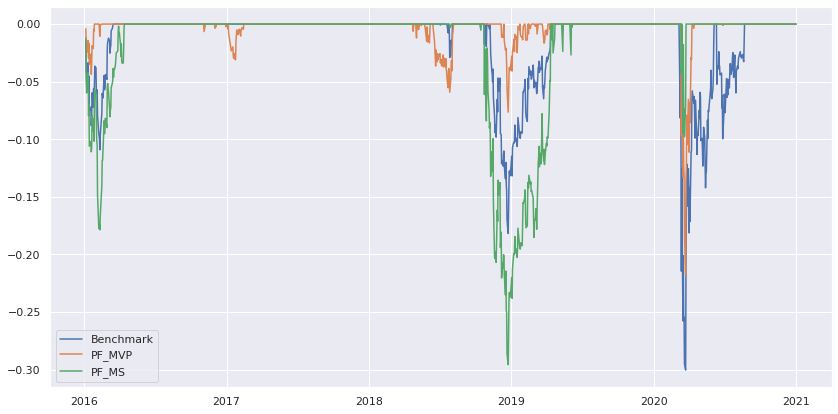

In [18]:
# Function to compute rolling drawdown
pf_only1 = data_ret2[["Benchmark", "PF_MVP", "PF_MS"]]        
pf_only2 = data_alt1[["Benchmark", "PF_MSV", "PF_MCVaR", "PF_MCDaR", "PF_HRP"]]

def get_rolling_drawdown(returns_df, window=126):
    """
    Compute rolling drawdown (peak-to-trough decline) for a given time window (in days).
    ARGUMENTS:
    - returns_df = pandas df, portfolio returns
    - window = int, number of months (default 6 months)
    OUTPUT: pandas DataFrame, single/multiple rolling drawdown columns
    """
    dd = pd.DataFrame(index=returns_df.index)
    for tick in returns_df.columns:
        # sum the returns in the given window (get the grawdown for day t using past n days data)
        roll_sum = returns_df[tick].rolling(window, min_periods=1).sum()
        # We only want the negative sums (peak-to-trough decline), set to zero if the sum is positive
        roll_sum[roll_sum > 0.0] = 0.0
        # You can add this next commented line if you want a smoothed value (get the minimun value for the sums over a certain time window)
        # roll_sum = roll_sum.rolling(10).min()
        dd[tick] = roll_sum
    return dd

# Example of output
rolldd_df = get_rolling_drawdown(pf_only1)

plt.figure(figsize=(14,7))
plt.plot(rolldd_df)
plt.legend(rolldd_df.columns);

In [19]:
# Function to generate performance report
def historical_VaR_ES(returns_df, cl=99):
    """
    Create a dataframe with a summary of some return and risk measures
    ARGUMENTS: 
    - returns_df = pandas df, portfolio returns
    - cl = float, confidence level for VaR/ES
    OUTPUT: pandas DataFrame, VaR & ES
    """
    vares = pd.DataFrame(index=["VaR", "ES"], columns=returns_df.columns)
    for tick in returns_df.columns:
        VaR = np.percentile(returns_df[tick], (100-cl))
        # var and es defined as positive numbers
        vares.loc["VaR", tick] = -VaR
        vares.loc["ES", tick] = -(np.mean(returns_df[tick][returns_df[tick] < VaR]))
    return vares

def Performance_Report(returns_df):
    """
    Create a dataframe with a summary of some return and risk measures
    ARGUMENTS: 
    - returns_df = pandas df, portfolio returns
    OUTPUT: pandas DataFrame, perfromance metrics
    """
    perfmetrics = pd.DataFrame(columns=returns_df.columns)
    dd = get_rolling_drawdown(returns_df=returns_df)
    df_vares = historical_VaR_ES(returns_df=returns_df)

    for tick in returns_df.columns:
        
        totret = returns_df[tick].sum()   # only for log_ret (add if statement to handle arithmetic)
        avgret = returns_df[tick].mean()
        stdev = returns_df[tick].std()
        semi_dev = (returns_df[tick][returns_df[tick] < returns_df[tick].mean()]).std()  # standard dev of returns below the average
        SH = avgret/stdev
        SR = avgret/semi_dev
        min_dd = dd[tick].min()  # select the lowest value over the entire sample period 

        # in percentage
        perfmetrics.loc["Total return", tick] = round(totret, 2)
        perfmetrics.loc["Daily Avg. Return", tick] = round(avgret, 5)
        perfmetrics.loc["Daily Volatility", tick] = round(stdev, 4)
        perfmetrics.loc["Daily SemiDeviation", tick] = round(semi_dev, 4)
        perfmetrics.loc["Sharpe Ratio", tick] = round(SH, 3)
        perfmetrics.loc["Sortino Ratio", tick] = round(SR, 3)
        perfmetrics.loc["6m Max Rolling DD", tick] = round(min_dd, 2)
        perfmetrics.loc["Daily 99% VaR", tick] = round(df_vares.loc["VaR", tick], 3)
        perfmetrics.loc["Daily 99% ES", tick] = round(df_vares.loc["ES", tick], 3)

    return perfmetrics
  

# CHECK
report = Performance_Report(pf_only1)
report

,Benchmark,PF_MVP,PF_MS
Total return,0.84,0.71,1.54
Daily Avg. Return,0.00067,0.00056,0.00122
Daily Volatility,0.0131,0.0102,0.0166
Daily SemiDeviation,0.0118,0.0092,0.0139
Sharpe Ratio,0.051,0.055,0.073
Sortino Ratio,0.056,0.061,0.088
6m Max Rolling DD,-0.3,-0.22,-0.3
Daily 99% VaR,0.04,0.032,0.046
Daily 99% ES,0.063,0.049,0.068


In [20]:
report2 = Performance_Report(pf_only2)
report2

,Benchmark,PF_MSV,PF_MCVaR,PF_MCDaR,PF_HRP
Total return,0.84,0.73,0.8,0.71,0.8
Daily Avg. Return,0.00067,0.00058,0.00064,0.00057,0.00064
Daily Volatility,0.0131,0.0101,0.0102,0.0109,0.0109
Daily SemiDeviation,0.0118,0.009,0.0089,0.0094,0.0097
Sharpe Ratio,0.051,0.057,0.063,0.052,0.058
Sortino Ratio,0.056,0.065,0.072,0.06,0.066
6m Max Rolling DD,-0.3,-0.2,-0.18,-0.17,-0.22
Daily 99% VaR,0.04,0.03,0.031,0.032,0.031
Daily 99% ES,0.063,0.047,0.047,0.048,0.052
